In [14]:
import random
from sage.graphs.graph_generators_pyx import RandomGNP

def I(n):
    return identity_matrix(n)

def J(n):
    return matrix(n,n,lambda x,y: 1)

def cfun_gen(i,j,n,kr,kc,l):
    return binomial(kr-i,l-i)*binomial(n-kr-j+i,kc-l-j+i)

def ffun_gen(i, j, n, kr, kc, l):
    xx = 0
    for v in range(i+1):
        xx += ((-1)^(i+v))*binomial(i,v)*cfun_gen(v,j,n,kr,kc,l)
    return xx
     
# builds the incidence matrix of i-sets vs n-sets of an m-element set with the relation being intersection in a set of size t
def intermtx(i, n, m, t):  
    row_size = binomial(m,i)
    col_size = binomial(m,n)
    R = Subsets(m,i)
    S = Subsets(m,n)
    W = matrix(ZZ, row_size, col_size)
    for i in range(row_size):
        for j in range(col_size):
            X = R[i].intersection(S[j])
            if X.cardinality() == t:
                W[i,j] = 1
    return W

#Gives the elementary divisors and multiplicities.
def el(W):
    e = W.elementary_divisors()
    d = dict((i, e.count(i)) for i in e)
    return d



#returns the matrix M_s
def m_matrix(l, kr, kc, n, s):
    M = matrix(ZZ, kr+1-s, kc+1-s)
    for i in range(kr+1-s):
        for j in range(i,kc+1-s):
            M[i,j] = binomial(j,i)*ffun_gen(i+s,j+s,n,kr,kc,l)
    return M

#returns multiplicity of copies of the M_s matrix 
def m_mult(n,s):
    c = (binomial(n,s)-binomial(n,s-1))-(binomial(n,s-1)-binomial(n,s-2))
    return c


def e_val(G):
    A = G
    if isinstance(A, Graph):
        A = G.adjacency_matrix()
    e = A.eigenvalues()
    d = dict((i, e.count(i)) for i in e)
    return d        

def tri_construct(G):
    done_cycles = []
    H = graphs.EmptyGraph()
    cycles = filter(lambda x: len(x)==4 and x[1]<x[-2], list(G.to_directed().all_cycles_iterator(simple=true, max_length=3)))
    print("Cycles Calculated.")
    vertex = 0
    for cycle in cycles:
        H.add_vertex(vertex)
        for done_cycle in done_cycles:
            adjacents = list(set(cycle).intersection(done_cycle))
            if len(adjacents) > 0:
                H.add_edge(vertex, done_cycles.index(done_cycle))
        done_cycles.append(cycle)
        vertex += 1
    return H

def clique_construct(G, size):
    done_cliques = []
    H = graphs.EmptyGraph()
    cliques = list(sage.graphs.cliquer.all_cliques(G, min_size = size, max_size = size))
    print("Cliques Calculated.")
    vertex = 0
    for clique in cliques:
        H.add_vertex(vertex)
        for done_clique in done_cliques:
            adjacents = list(set(clique).intersection(done_clique))
            if len(adjacents) > 0:
                H.add_edge(vertex, done_cliques.index(done_clique))
        done_cliques.append(clique)
        vertex += 1
    return H

def is_induced_subgraph(G, r, s):
    outside = 0
    for e in e_val(G).keys():
        if s > e or e > r:
            outside += 1
    if outside != 1:
        return false
    return true

def smith_order(eigens):
    order = 1
    for key in eigens.keys():
        order *= abs(key) ** eigens.get(key)
    factors = factor(order)
    result = dict()
    for f in factors:
        result.update({f[0]:f[1]})
    return result

def violates_adjacents(G, u, v, l):
    return len(list(set(G.neighbors(u)).intersection(G.neighbors(v)))) > l

def violates_non_adjacents(G, u, v, m):
    return len(list(set(G.neighbors(u)).intersection(G.neighbors(v)))) > m

def violates_rules(G, k, l, m, readout = False, ignore_degree = False):
    for u in G.vertices():
        if not ignore_degree and G.degree(u) != k:
            if readout:
                print("Violates Degree Rule. Degree of ", u, " is ", G.degree(u))
            return True
        for v in G.vertices():
            if u != v:
                if G.has_edge(u, v) and violates_adjacents(G, u, v, l):
                    if readout:
                        print("Violates Adjacents Rule on Vertices: ", u, v, end=", ")
                    return True
                elif violates_non_adjacents(G, u, v, m):
                    if readout:
                        print("Violates Non-Adjacents Rule on Vertices: ", u, v, end=", ")
                    return True
    return False

def insert_edge(G, k, u, v):
    if G.degree(u) != k and G.degree(v) != k and len(list(set(u.neighbors()).intersection(v.neighbors()))) <= 1:
        G.add_edge(u,v)

def adjacency_eigenvalues(v, k, l, m):
    r = int(0.5 * ((l - m) + sqrt((l - m) ** 2 + 4 * (k - m))))
    f = int(0.5 * ((v - 1) - (2 * k + (v - 1) * (l - m)) / (sqrt((l - m) ** 2 + 4 * (k - m)))))
    s = int(0.5 * ((l - m) - sqrt((l - m) ** 2 + 4 * (k - m))))
    g = int(0.5 * ((v - 1) + (2 * k + (v - 1) * (l - m)) / (sqrt((l - m) ** 2 + 4 * (k - m)))))
    return {k:1, r:f, s:g}

def laplacian_eigens(k, r, f, s , g):
    print(str(k - r)+"^"+str(f), str(k - s)+"^"+str(g))

# eigens is the dictonary of the laplacian eigenvalues and multiplicies excluding 0 eigenvalues
# entries of eigens are as such {eigenvalues: multiplicity}
def critical_group(v, r, f, s, g):
    order = (r ** f * s ** g) / v
    print("K(L) ~ ", end="")
    plus = False
    for p, _ in factor(order):
        if plus:
            print(" + ", end="")
        if r % p == 0 and s % p == 0:
            y = 1
            while v % p ** y == 0:
                y += 1
            y -= 1
            print("(ZZ/"+str(p)+"ZZ)^"+str(f+g+y)+"-2e0"+"+"+"(ZZ/"+str(p ** 2)+"ZZ)^"+"e0-"+str(y), end="")
        elif r % p != 0:
            a = 1
            while s % p ** a == 0:
                a += 1
            a -= 1

            y = 1
            while v % p ** y == 0:
                y += 1
            y -= 1

            if y == 0:
                print("(ZZ/"+str(p ** a)+"ZZ)^"+str(g), end="")
            elif 0 < y < a:
                print("ZZ/"+str(p ** (a - y))+"ZZ+"+"(ZZ/"+str(p ** a)+"ZZ)^"+str(g - 1), end="")
            elif y == a:
                print("(ZZ/"+str(p ** a)+"ZZ)^"+str(g - 1), end="")
            else:
                print("Error: y="+str(y)+" a="+str(a))
        elif s % p != 0:
            a = 1
            while r % p ** a == 0:
                a += 1
            a -= 1

            y = 1
            while v % p ** y == 0:
                y += 1
            y -= 1

            if y == 0:
                print("(ZZ/"+str(p ** a)+"ZZ)^"+str(f), end="")
            elif 0 < y < a:
                print("ZZ/"+str(p ** (a - y))+"ZZ+"+"(ZZ/"+str(p ** a)+"ZZ)^"+str(f - 1), end="")
            elif y == a:
                print("(ZZ/"+str(p ** a)+"ZZ)^"+str(f - 1), end="")
            else:
                print("Error: y="+str(y)+" a="+str(a))
        else:
            print("Error")
        plus = True
    print()

def print_parameters(G):
    adjacent = False
    not_adjacent = False
    num_of_vertices = len(G.vertices())
    k = G.average_degree()
    l = 0
    m = 0
    for v in G.vertices():
        for u in G.vertices():
            if v != u and G.has_edge(v, u):
                l = len(list(set(G.neighbors(v)).intersection(G.neighbors(u))))
                adjacent = True
            elif v != u and not G.has_edge(v, u):
                m = len(list(set(G.neighbors(v)).intersection(G.neighbors(u))))
                not_adjacent = True
            if adjacent and not_adjacent:
                print(num_of_vertices, k, l, m)
                return num_of_vertices, k, l, m

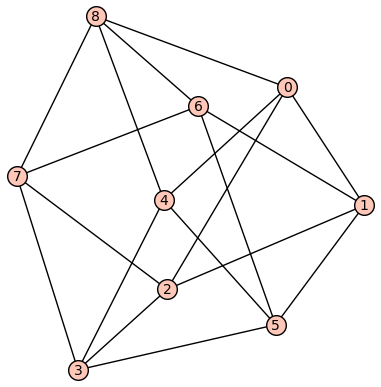

[0 1 1 0 1 0 0 0 1]
[1 0 1 0 0 1 1 0 0]
[1 1 0 1 0 0 0 1 0]
[0 0 1 0 1 1 0 1 0]
[1 0 0 1 0 1 0 0 1]
[0 1 0 1 1 0 1 0 0]
[0 1 0 0 0 1 0 1 1]
[0 0 1 1 0 0 1 0 1]
[1 0 0 0 1 0 1 1 0]
{4: 1, 1: 4, -2: 4}
Violates Rules? False


In [2]:
Paley9 = Graph(graphs.PaleyGraph(9).adjacency_matrix())
Paley9.show()
print(Paley9.adjacency_matrix())
print(e_val(Paley9))
print("Violates Rules?", violates_rules(Paley9, 4, 1, 2))

In [3]:
L = Paley9.laplacian_matrix()
print(L.elementary_divisors())
D, P, Q = L.smith_form()
P*L*Q==D

[1, 1, 1, 1, 6, 6, 18, 18, 0]


True

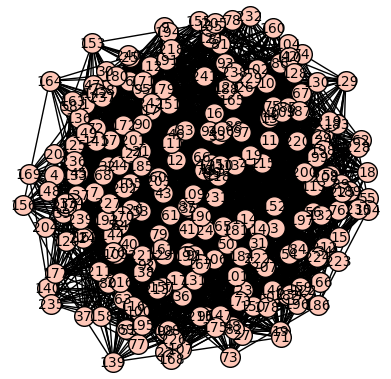

Violates Rules? False


In [4]:
G243 = graphs.strongly_regular_graph(243,22,1,2)
G243.show()
print("Violates Rules?", violates_rules(G243, 22, 1, 2))

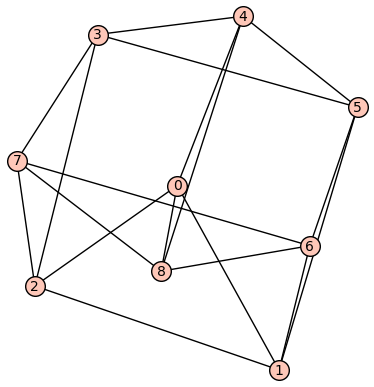

Cycles Calculated.


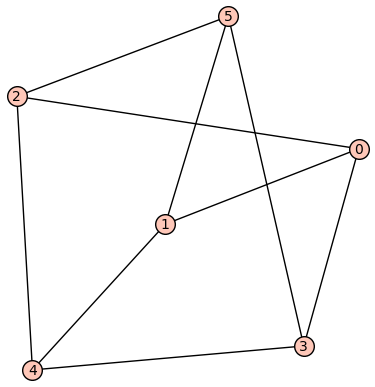

In [5]:
G = Graph(graphs.PaleyGraph(9).adjacency_matrix())
G.show()
H = tri_construct(G)
H.show()

In [6]:
print(len(H.vertices()))
print(e_val(H))
print(e_val(G))
print(H.is_distance_regular())

6
{3: 1, -3: 1, 0: 4}
{4: 1, 1: 4, -2: 4}
True


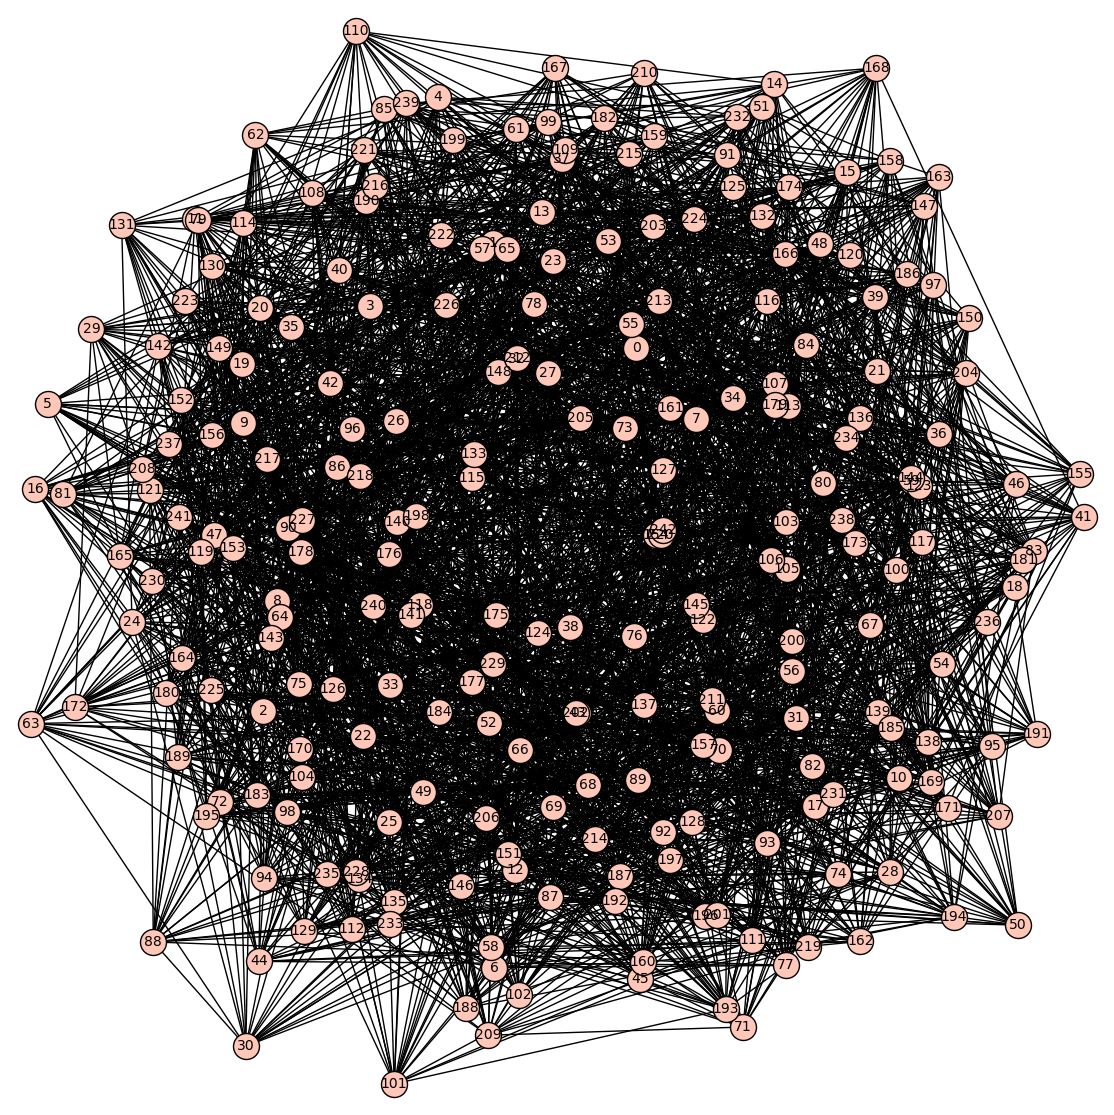

Cycles Calculated.


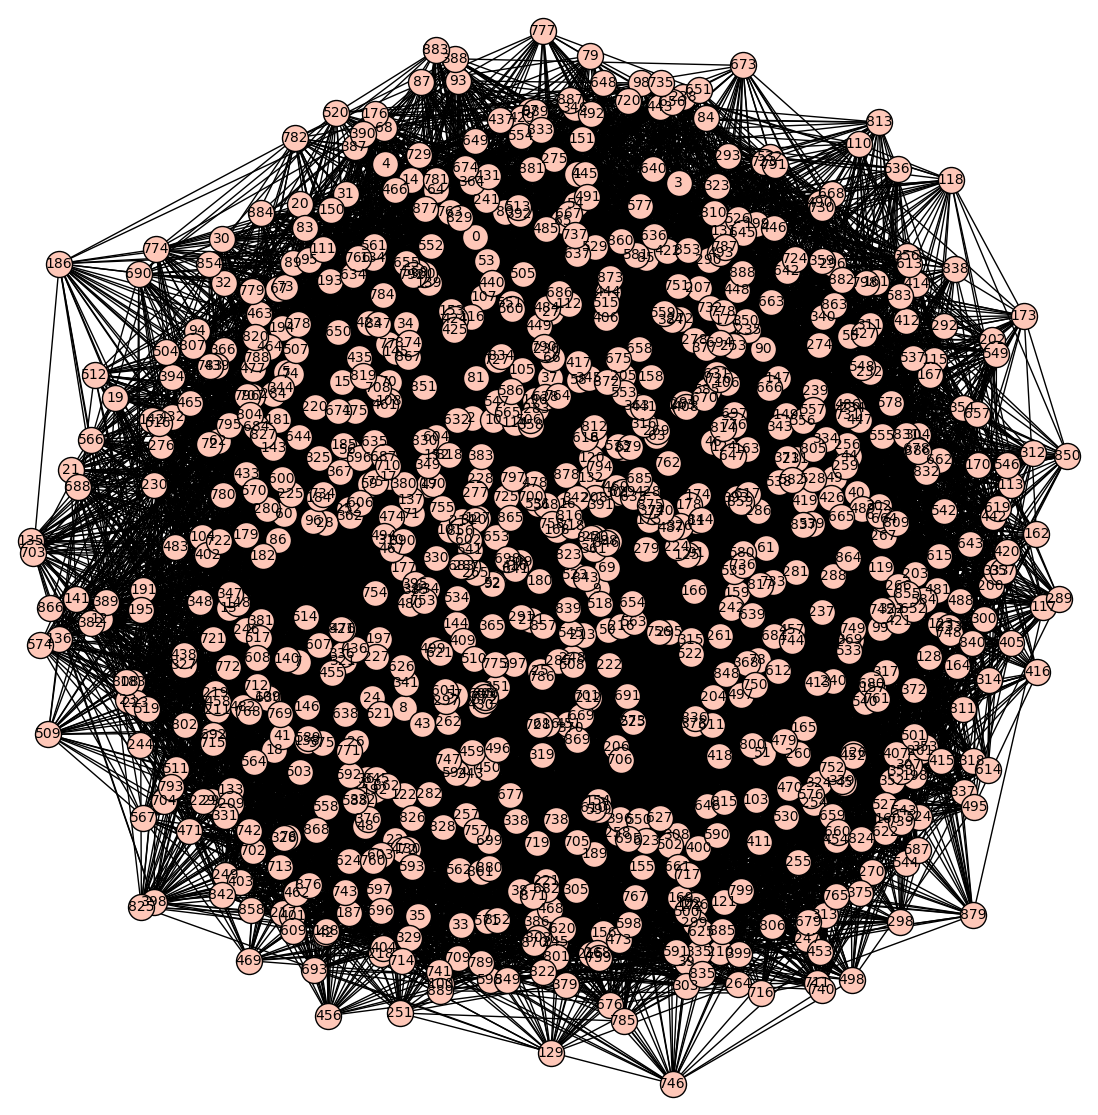

In [18]:
G = graphs.strongly_regular_graph(243,22,1,2)
G.show(figsize=15, vertex_size=350)
H = tri_construct(G)
H.show(figsize=15, vertex_size=350)

In [19]:
print(len(H.vertices()))
print(e_val(H))
print(e_val(G))
print(H.is_distance_regular())
print(H.is_regular())

891
{30: 1, 3: 110, 12: 132, -3: 648}
{22: 1, -5: 110, 4: 132}
False
True


In [20]:
cycles = list(filter(lambda x: len(x)==4 and x[1]<x[-2], list(G.to_directed().all_cycles_iterator(simple=true, max_length=3))))
print(len(cycles))

891


In [24]:
connections = dict()
done = []
for cycle_a in cycles:
    done.append(cycle_a)
    for cycle_b in cycles:
        count = 0
        if cycle_b not in done and len(list(set(cycle_a).intersection(cycle_b))) == 0:
            for point_a in set(cycle_a):
                for point_b in set(cycle_b):
                    if G.has_edge(point_a, point_b):
                        count += 1
            if count in connections.keys():
                connections.update({count: connections.get(count) + 1})
            else:
                connections.update({count: 1})
print(connections)

{0: 133650, 1: 240570, 3: 8910}


In [49]:
G1 = Graph(graphs.strongly_regular_graph(9,4,1,2))
G2 = Graph(graphs.strongly_regular_graph(15,6,1,3))
G3 = Graph(graphs.strongly_regular_graph(27,10,1,5))
G4 = Graph(graphs.strongly_regular_graph(81,20,1,6))
G5 = Graph(graphs.strongly_regular_graph(243,22,1,2))
G6 = Graph(graphs.strongly_regular_graph(378,52,1,8))
G7 = Graph(graphs.strongly_regular_graph(729,112,1,20))

i = 1
for G in [G1, G2, G3, G4, G5]:
    print("G"+str(i)+":")
    cycles = list(filter(lambda x: len(x)==4 and x[1]<x[-2], list(G.to_directed().all_cycles_iterator(simple=true, max_length=3))))
    connections = dict()
    done = []
    for cycle_a in cycles:
        done.append(cycle_a)
        for cycle_b in cycles:
            count = 0
            if cycle_b not in done and len(list(set(cycle_a).intersection(cycle_b))) == 0:
                for point_a in set(cycle_a):
                    for point_b in set(cycle_b):
                        if G.has_edge(point_a, point_b):
                            count += 1
                if count in connections.keys():
                    connections.update({count: connections.get(count) + 1})
                else:
                    connections.update({count: 1})
    print(connections)
    i += 1

G1:
{3: 6}
G2:
{3: 2160}
G3:
{3: 720}
G4:
{3: 2430, 2: 29160, 0: 1080}
G5:
{0: 133650, 1: 240570, 3: 8910}


In [61]:
import json
from sage.features.databases import DatabaseGraphs
data_dir = os.path.dirname(DatabaseGraphs().absolute_filename())
filename = os.path.join(data_dir, 'brouwer_srg_database.json')
with open(filename) as fobj:
    database = json.load(fobj)
srg_database = list(filter(lambda x: x[4] == 'exists', database))
srg_database = list(map(lambda x: x[:4], srg_database))

In [20]:
clique_size = 3
num_of_cliques = 2
CG2s = list(filter(lambda x: x[4] == 'exists' and x[2] != 0 and (x[1] / x[3]) + 1 == clique_size, database))
CG2s = list(map(lambda x: x[:4], CG2s))
print(CG2s)

[[9, 4, 1, 2], [13, 6, 2, 3], [15, 6, 1, 3], [15, 8, 4, 4], [17, 8, 3, 4], [25, 12, 5, 6], [27, 10, 1, 5], [27, 16, 10, 8], [29, 14, 6, 7], [35, 16, 6, 8], [35, 18, 9, 9], [37, 18, 8, 9], [41, 20, 9, 10], [45, 22, 10, 11], [49, 24, 11, 12], [53, 26, 12, 13], [61, 30, 14, 15], [63, 30, 13, 15], [63, 32, 16, 16], [65, 32, 15, 16], [73, 36, 17, 18], [81, 40, 19, 20], [89, 44, 21, 22], [97, 48, 23, 24], [99, 48, 22, 24], [99, 50, 25, 25], [101, 50, 24, 25], [109, 54, 26, 27], [113, 56, 27, 28], [119, 54, 21, 27], [119, 64, 36, 32], [121, 60, 29, 30], [125, 52, 15, 26], [125, 62, 30, 31], [125, 72, 45, 36], [135, 64, 28, 32], [135, 70, 37, 35], [137, 68, 33, 34], [143, 70, 33, 35], [143, 72, 36, 36], [149, 74, 36, 37], [157, 78, 38, 39], [169, 84, 41, 42], [173, 86, 42, 43], [175, 72, 20, 36], [175, 102, 65, 51], [181, 90, 44, 45], [193, 96, 47, 48], [195, 96, 46, 48], [195, 98, 49, 49], [197, 98, 48, 49], [209, 100, 45, 50], [209, 108, 57, 54], [225, 112, 55, 56], [229, 114, 56, 57], [233,

In [20]:
locally_linear = list(map(lambda x: x[:4], list(filter(lambda x: x[2] == 1, database))))
locally_linear.append([6273, 112, 1, 2])
locally_linear.append([494019, 994, 1, 2])
print(locally_linear)

[[9, 4, 1, 2], [15, 6, 1, 3], [27, 10, 1, 5], [57, 14, 1, 4], [63, 22, 1, 11], [81, 20, 1, 6], [99, 14, 1, 2], [115, 18, 1, 3], [225, 56, 1, 18], [243, 22, 1, 2], [289, 54, 1, 12], [378, 52, 1, 8], [495, 38, 1, 3], [507, 44, 1, 4], [630, 68, 1, 8], [729, 112, 1, 20], [729, 182, 1, 60], [6273, 112, 1, 2], [494019, 994, 1, 2]]


In [21]:
triangle_graphs = []
for v, k, _, _ in locally_linear:
    triangle_graphs.append([(v * k) / 6, (3 * (k - 2)) / 2, (k - 4) / 2, (9 * (k - 2) ** 2) / (k * v - 9 * k + 12)])
print(triangle_graphs)

[[6, 3, 0, 3], [15, 6, 1, 3], [45, 12, 3, 3], [133, 18, 5, 36/19], [231, 30, 9, 3], [270, 27, 8, 243/121], [231, 18, 5, 54/53], [345, 24, 7, 6/5], [2100, 81, 26, 2187/1009], [891, 30, 9, 30/43], [2601, 78, 25, 156/97], [3276, 75, 24, 75/64], [3135, 54, 17, 243/385], [3718, 63, 20, 21/29], [7140, 99, 32, 297/320], [13608, 165, 54, 825/611], [22113, 270, 89, 24300/10921], [117096, 165, 54, 165/1063], [81842481, 1488, 495, 1488/82501]]


In [22]:
locally_linear_eigenvalues = list(map(lambda x: adjacency_eigenvalues(x[0], x[1], x[2], x[3]), locally_linear))
print(locally_linear_eigenvalues)

[{4: 1, 1: 4, -2: 4}, {6: 1, 1: 9, -3: 5}, {10: 1, 1: 20, -5: 6}, {14: 1, 2: 38, -5: 18}, {22: 1, 1: 55, -11: 7}, {20: 1, 2: 60, -7: 20}, {14: 1, 3: 54, -4: 44}, {18: 1, 3: 69, -5: 45}, {56: 1, 2: 200, -19: 24}, {22: 1, 4: 132, -5: 110}, {54: 1, 3: 234, -14: 54}, {52: 1, 4: 273, -11: 104}, {38: 1, 5: 285, -7: 209}, {44: 1, 5: 308, -8: 198}, {68: 1, 5: 440, -12: 189}, {112: 1, 4: 616, -23: 112}, {182: 1, 2: 702, -61: 26}, {112: 1, 10: 3280, -11: 2992}, {994: 1, 31: 250914, -32: 243104}]


In [23]:
for i in range(len(locally_linear)):
    print(locally_linear[i], end="    ")
    k = locally_linear[i][1]
    print(-3, int((3.0 / 2.0) * (k - 2.0)))

[9, 4, 1, 2]    -3 3
[15, 6, 1, 3]    -3 6
[27, 10, 1, 5]    -3 12
[57, 14, 1, 4]    -3 18
[63, 22, 1, 11]    -3 30
[81, 20, 1, 6]    -3 27
[99, 14, 1, 2]    -3 18
[115, 18, 1, 3]    -3 24
[225, 56, 1, 18]    -3 81
[243, 22, 1, 2]    -3 30
[289, 54, 1, 12]    -3 78
[378, 52, 1, 8]    -3 75
[495, 38, 1, 3]    -3 54
[507, 44, 1, 4]    -3 63
[630, 68, 1, 8]    -3 99
[729, 112, 1, 20]    -3 165
[729, 182, 1, 60]    -3 270
[6273, 112, 1, 2]    -3 165
[494019, 994, 1, 2]    -3 1488


In [11]:
for s in range(4):
    M = m_matrix(1,3,3,99,s)
    print("M",s,"= ")
    print(M)
    print("mult: ", m_mult(99,s))
    print(el(M))
    print(" ")

M 0 = 
[13680   285     3     0]
[    0  4275   184     3]
[    0     0  -187    -6]
[    0     0     0     3]
mult:  1
{1: 1, 3: 1, 285: 1, 38372400: 1}
 
M 1 = 
[4275   92    1]
[   0 -187   -4]
[   0    0    3]
mult:  97
{1: 2, 2398275: 1}
 
M 2 = 
[-187   -2]
[   0    3]
mult:  4654
{1: 1, 561: 1}
 
M 3 = 
[3]
mult:  147246
{3: 1}
 


In [12]:
eigens99 = {14:1,3:54,-4:44}
smith_order(eigens99)

{2: 89, 3: 54, 7: 1}

In [13]:
eigens9 = {4:1, 1:4, -2: 4}
smith_order(eigens9)

{2: 6}

In [49]:
U, A, V = G.adjacency_matrix().smith_form()
print(U, "\n", A, "\n", V)
G.adjacency_matrix().elementary_divisors()

KeyboardInterrupt: 

In [ ]:
U, L, V = G.laplacian_matrix().smith_form()
print(U, "\n", L, "\n", V)
G.laplacian_matrix().elementary_divisors()

In [ ]:
L == A

In [16]:
PG = graphs.PetersenGraph()
print(PG.adjacency_matrix().elementary_divisors())
print(PG.laplacian_matrix().elementary_divisors())

[1, 1, 1, 1, 1, 1, 2, 2, 2, 6]
[1, 1, 1, 1, 1, 2, 10, 10, 10, 0]


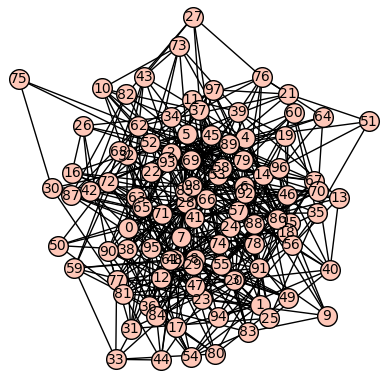

475 99


In [17]:
seed_modifier = 0
G99 = RandomGNP(99, .1, directed=False, seed=seed_modifier)
G99.show()
print(len(G99.edges()), len(G99.vertices()))

In [18]:
import random
rand = random.seed("Conway99")

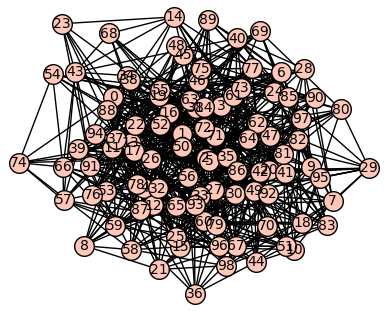

Violates Non-Adjacents Rule on Vertices:  0 1, Violates Rules? True


In [19]:
G99 = graphs.RandomGNM(99, 693, seed = rand) #693 is the ideal
G99.show()
print("Violates Rules?", violates_rules(G99, 14, 1, 2, readout = True, ignore_degree = True))

In [20]:
def steiner(params):
    system = []
    file1 = open('steiner_systems/steiner'+str(params)+'.txt', 'r')
    Lines = file1.readlines()
     
    for line in Lines:
        block = []
        words = line.strip().split()
        for word in words:
            block.append(eval(word))
        system.append(block)
    return system

In [106]:
S = steiner("(3,6,22)")
print(S)

[[1, 2, 3, 4, 5, 6], [1, 2, 7, 8, 9, 10], [1, 2, 11, 12, 13, 14], [1, 2, 15, 16, 17, 18], [1, 2, 19, 20, 21, 22], [1, 3, 7, 11, 15, 19], [1, 3, 8, 12, 16, 20], [1, 3, 9, 13, 17, 21], [1, 3, 10, 14, 18, 22], [1, 4, 7, 12, 17, 22], [1, 4, 8, 11, 18, 21], [1, 4, 9, 14, 15, 20], [1, 4, 10, 13, 16, 19], [1, 5, 7, 13, 18, 20], [1, 5, 8, 14, 17, 19], [1, 5, 9, 11, 16, 22], [1, 5, 10, 12, 15, 21], [1, 6, 7, 14, 16, 21], [1, 6, 8, 13, 15, 22], [1, 6, 9, 12, 18, 19], [1, 6, 10, 11, 17, 20], [2, 3, 7, 12, 18, 21], [2, 3, 8, 11, 17, 22], [2, 3, 9, 14, 16, 19], [2, 3, 10, 13, 15, 20], [2, 4, 7, 11, 16, 20], [2, 4, 8, 12, 15, 19], [2, 4, 9, 13, 18, 22], [2, 4, 10, 14, 17, 21], [2, 5, 7, 14, 15, 22], [2, 5, 8, 13, 16, 21], [2, 5, 9, 12, 17, 20], [2, 5, 10, 11, 18, 19], [2, 6, 7, 13, 17, 19], [2, 6, 8, 14, 18, 20], [2, 6, 9, 11, 15, 21], [2, 6, 10, 12, 16, 22], [3, 4, 7, 8, 13, 14], [3, 4, 9, 10, 11, 12], [3, 4, 15, 16, 21, 22], [3, 4, 17, 18, 19, 20], [3, 5, 7, 10, 16, 17], [3, 5, 8, 9, 15, 18], [3, 

In [22]:
count = dict()
for block in S:
    for element in block:
        if element in count.keys():
            count.update({element: count.get(element) + 1})
        else:
            count.update({element: 1})
print(count)

{1: 21, 2: 21, 3: 21, 4: 21, 5: 21, 6: 21, 7: 21, 8: 21, 9: 21, 10: 21, 11: 21, 12: 21, 13: 21, 14: 21, 15: 21, 16: 21, 17: 21, 18: 21, 19: 21, 20: 21, 21: 21, 22: 21}


In [23]:
count = dict()
for element in range(1, 23):
    element_l = (element - 1) % 23
    if element_l == 0:
        element_l = 22
    element_r = (element + 1) % 23
    if element_r == 0:
        element_r = 1
    for block in S:
        if element in block and element_l in block and element_r in block:
            if element in count.keys():
                count.update({element: count.get(element) + 1})
            else:
                count.update({element: 1})
print(count)

{1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1}


In [24]:
count = dict()
for element in range(1, 23):
    element_l = (element - 1) % 23
    if element_l == 0:
        element_l = 22
    element_r = (element + 1) % 23
    if element_r == 0:
        element_r = 1
    for block in S:
        if element_l in block and element_r in block:
            if element in count.keys():
                count.update({element: count.get(element) + 1})
            else:
                count.update({element: 1})
print(count)

{1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5, 10: 5, 11: 5, 12: 5, 13: 5, 14: 5, 15: 5, 16: 5, 17: 5, 18: 5, 19: 5, 20: 5, 21: 5, 22: 5}


In [25]:
count = dict()
for element in range(1, 23):
    element_l = (element - 1) % 23
    if element_l == 0:
        element_l = 22
    element_r = (element + 1) % 23
    if element_r == 0:
        element_r = 1
    for block in S:
        if (element in block and element_r in block) or (element in block and element_l in block):
            if element in count.keys():
                count.update({element: count.get(element) + 1})
            else:
                count.update({element: 1})
print(count)

{1: 9, 2: 9, 3: 9, 4: 9, 5: 9, 6: 9, 7: 9, 8: 9, 9: 9, 10: 9, 11: 9, 12: 9, 13: 9, 14: 9, 15: 9, 16: 9, 17: 9, 18: 9, 19: 9, 20: 9, 21: 9, 22: 9}


In [26]:
count = dict()
for block1 in S:
    for block2 in S:
        if block1 != block2 and len(list(set(block1).intersection(block2))) == 0:
            block1 = tuple(block1)
            if block1 in count.keys():
                count.update({block1: count.get(block1) + 1})
            else:
                count.update({block1: 1})
print(count)

{(1, 2, 3, 4, 5, 6): 16, (1, 2, 7, 8, 9, 10): 16, (1, 2, 11, 12, 13, 14): 16, (1, 2, 15, 16, 17, 18): 16, (1, 2, 19, 20, 21, 22): 16, (1, 3, 7, 11, 15, 19): 16, (1, 3, 8, 12, 16, 20): 16, (1, 3, 9, 13, 17, 21): 16, (1, 3, 10, 14, 18, 22): 16, (1, 4, 7, 12, 17, 22): 16, (1, 4, 8, 11, 18, 21): 16, (1, 4, 9, 14, 15, 20): 16, (1, 4, 10, 13, 16, 19): 16, (1, 5, 7, 13, 18, 20): 16, (1, 5, 8, 14, 17, 19): 16, (1, 5, 9, 11, 16, 22): 16, (1, 5, 10, 12, 15, 21): 16, (1, 6, 7, 14, 16, 21): 16, (1, 6, 8, 13, 15, 22): 16, (1, 6, 9, 12, 18, 19): 16, (1, 6, 10, 11, 17, 20): 16, (2, 3, 7, 12, 18, 21): 16, (2, 3, 8, 11, 17, 22): 16, (2, 3, 9, 14, 16, 19): 16, (2, 3, 10, 13, 15, 20): 16, (2, 4, 7, 11, 16, 20): 16, (2, 4, 8, 12, 15, 19): 16, (2, 4, 9, 13, 18, 22): 16, (2, 4, 10, 14, 17, 21): 16, (2, 5, 7, 14, 15, 22): 16, (2, 5, 8, 13, 16, 21): 16, (2, 5, 9, 12, 17, 20): 16, (2, 5, 10, 11, 18, 19): 16, (2, 6, 7, 13, 17, 19): 16, (2, 6, 8, 14, 18, 20): 16, (2, 6, 9, 11, 15, 21): 16, (2, 6, 10, 12, 16, 22)

In [27]:
count = dict()
for block in S:
    for element in Combinations(block, 2).list():
        element = tuple(element)
        if element in count.keys():
            count.update({element: count.get(element) + 1})
        else:
            count.update({element: 1})
print(count)

{(1, 2): 5, (1, 3): 5, (1, 4): 5, (1, 5): 5, (1, 6): 5, (2, 3): 5, (2, 4): 5, (2, 5): 5, (2, 6): 5, (3, 4): 5, (3, 5): 5, (3, 6): 5, (4, 5): 5, (4, 6): 5, (5, 6): 5, (1, 7): 5, (1, 8): 5, (1, 9): 5, (1, 10): 5, (2, 7): 5, (2, 8): 5, (2, 9): 5, (2, 10): 5, (7, 8): 5, (7, 9): 5, (7, 10): 5, (8, 9): 5, (8, 10): 5, (9, 10): 5, (1, 11): 5, (1, 12): 5, (1, 13): 5, (1, 14): 5, (2, 11): 5, (2, 12): 5, (2, 13): 5, (2, 14): 5, (11, 12): 5, (11, 13): 5, (11, 14): 5, (12, 13): 5, (12, 14): 5, (13, 14): 5, (1, 15): 5, (1, 16): 5, (1, 17): 5, (1, 18): 5, (2, 15): 5, (2, 16): 5, (2, 17): 5, (2, 18): 5, (15, 16): 5, (15, 17): 5, (15, 18): 5, (16, 17): 5, (16, 18): 5, (17, 18): 5, (1, 19): 5, (1, 20): 5, (1, 21): 5, (1, 22): 5, (2, 19): 5, (2, 20): 5, (2, 21): 5, (2, 22): 5, (19, 20): 5, (19, 21): 5, (19, 22): 5, (20, 21): 5, (20, 22): 5, (21, 22): 5, (3, 7): 5, (3, 11): 5, (3, 15): 5, (3, 19): 5, (7, 11): 5, (7, 15): 5, (7, 19): 5, (11, 15): 5, (11, 19): 5, (15, 19): 5, (3, 8): 5, (3, 12): 5, (3, 16):

In [28]:
import numpy as np
diff = dict()
for block_a in S:
    for block_b in S:
        if block_a != block_b:
            key = tuple(block_a)
            if sum(abs(np.array(block_a) - np.array(block_b)) % 2) == 0:
                if key in diff.keys():
                    diff.update({key: diff.get(key) + 1})
                else:
                    diff.update({key: 1})
print(diff)

count = 0
for d in diff.keys():
    if diff.get(d) < 14:
        count += 1
print(count)

{(1, 2, 3, 4, 5, 6): 14, (1, 2, 7, 8, 9, 10): 14, (1, 2, 11, 12, 13, 14): 14, (1, 2, 15, 16, 17, 18): 14, (1, 2, 19, 20, 21, 22): 14, (1, 3, 7, 11, 15, 19): 1, (1, 3, 8, 12, 16, 20): 1, (1, 3, 9, 13, 17, 21): 1, (1, 3, 10, 14, 18, 22): 1, (1, 4, 7, 12, 17, 22): 14, (1, 4, 8, 11, 18, 21): 1, (1, 4, 9, 14, 15, 20): 14, (1, 4, 10, 13, 16, 19): 1, (1, 5, 7, 13, 18, 20): 1, (1, 5, 8, 14, 17, 19): 1, (1, 5, 9, 11, 16, 22): 1, (1, 5, 10, 12, 15, 21): 1, (1, 6, 7, 14, 16, 21): 1, (1, 6, 8, 13, 15, 22): 1, (1, 6, 9, 12, 18, 19): 1, (1, 6, 10, 11, 17, 20): 1, (2, 3, 7, 12, 18, 21): 1, (2, 3, 8, 11, 17, 22): 1, (2, 3, 9, 14, 16, 19): 1, (2, 3, 10, 13, 15, 20): 1, (2, 4, 7, 11, 16, 20): 1, (2, 4, 8, 12, 15, 19): 1, (2, 4, 9, 13, 18, 22): 1, (2, 4, 10, 14, 17, 21): 1, (2, 5, 7, 14, 15, 22): 1, (2, 5, 8, 13, 16, 21): 1, (2, 5, 9, 12, 17, 20): 1, (2, 5, 10, 11, 18, 19): 1, (2, 6, 7, 13, 17, 19): 1, (2, 6, 8, 14, 18, 20): 1, (2, 6, 9, 11, 15, 21): 1, (2, 6, 10, 12, 16, 22): 1, (3, 4, 7, 8, 13, 14): 14

In [29]:
C = Combinations(range(1, 23), 2).list()
print(len(C))
print(C)

231
[[1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [1, 9], [1, 10], [1, 11], [1, 12], [1, 13], [1, 14], [1, 15], [1, 16], [1, 17], [1, 18], [1, 19], [1, 20], [1, 21], [1, 22], [2, 3], [2, 4], [2, 5], [2, 6], [2, 7], [2, 8], [2, 9], [2, 10], [2, 11], [2, 12], [2, 13], [2, 14], [2, 15], [2, 16], [2, 17], [2, 18], [2, 19], [2, 20], [2, 21], [2, 22], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 15], [3, 16], [3, 17], [3, 18], [3, 19], [3, 20], [3, 21], [3, 22], [4, 5], [4, 6], [4, 7], [4, 8], [4, 9], [4, 10], [4, 11], [4, 12], [4, 13], [4, 14], [4, 15], [4, 16], [4, 17], [4, 18], [4, 19], [4, 20], [4, 21], [4, 22], [5, 6], [5, 7], [5, 8], [5, 9], [5, 10], [5, 11], [5, 12], [5, 13], [5, 14], [5, 15], [5, 16], [5, 17], [5, 18], [5, 19], [5, 20], [5, 21], [5, 22], [6, 7], [6, 8], [6, 9], [6, 10], [6, 11], [6, 12], [6, 13], [6, 14], [6, 15], [6, 16], [6, 17], [6, 18], [6, 19], [6, 20], [6, 21], [6, 22], [7, 8], [7, 9], [7, 10], [7, 

In [30]:
C = Combinations(range(1, 21), 3).list()
print(len(C))

1140


In [31]:
count = 0
for combo_a in C:
    for combo_b in C:
        if combo_a != combo_b and len(list(set(combo_a).intersection(combo_b))) == 0:
            for block in S:
                if set(combo_a).issubset(block) and set(combo_b).issubset(block):
                    count += 1
print(count/2)

400


In [32]:
Z9xZ11 = []
for i in range(9):
    for j in range(11):
        Z9xZ11.append([i,j])

In [33]:
count = 0
for combo_a in Z9xZ11:
    for combo_b in Z9xZ11:
        if combo_a != combo_b and len(list(set(combo_a).intersection(combo_b))) == 0:
            for block in S:
                if set(combo_a).issubset(block) and set(combo_b).issubset(block):
                    count += 1
print(count/2)

916


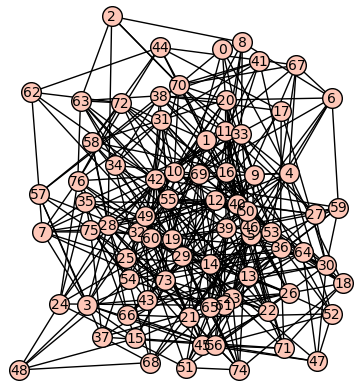

Violates Non-Adjacents Rule on Vertices:  0 6, Violates Rules? True


In [34]:
S77 = graphs.RandomGNM(77, 385, seed = rand) #This is an idea of what the 77 induced subgraph should look like
S77.show()
print("Violates Rules?", violates_rules(S77, 10, 1, 2, readout = True, ignore_degree = True))

In [35]:
v = 49
r = 14
f = 18
s = 21
g = 30
print(factor((r ** f * s ** g)/v))

2^18 * 3^30 * 7^46


In [37]:
critical_group(99, 11, 54, 18, 44)
critical_group(190, 80, 133, 95, 56)

K(L) ~ (ZZ/2ZZ)^44 + (ZZ/9ZZ)^43 + (ZZ/11ZZ)^53
K(L) ~ ZZ/8ZZ+(ZZ/16ZZ)^132 + (ZZ/5ZZ)^190-2e0+(ZZ/25ZZ)^e0-1 + (ZZ/19ZZ)^55


In [38]:
# Both of these do not exist
critical_group(57, 12, 38, 19, 18)
critical_group(57, 38, 18, 45, 38)

K(L) ~ (ZZ/4ZZ)^38 + (ZZ/3ZZ)^37 + (ZZ/19ZZ)^17
K(L) ~ (ZZ/2ZZ)^18 + ZZ/3ZZ+(ZZ/9ZZ)^37 + (ZZ/5ZZ)^38 + (ZZ/19ZZ)^17


In [39]:
# Both of these do exist
critical_group(55, 11, 10, 20, 44)
critical_group(55, 35, 44, 44, 10)

K(L) ~ (ZZ/4ZZ)^44 + (ZZ/5ZZ)^43 + (ZZ/11ZZ)^9
K(L) ~ (ZZ/4ZZ)^10 + (ZZ/5ZZ)^43 + (ZZ/7ZZ)^44 + (ZZ/11ZZ)^9


In [40]:
# Both of these are not know if they exist
laplacian_eigens(20, 5, 23, -3, 45)
laplacian_eigens(48, 2, 45, -6, 23)
critical_group(69, 15, 23, 23, 45)
critical_group(69, 46, 45, 54, 23)

15^23 23^45
46^45 54^23
K(L) ~ (ZZ/3ZZ)^22 + (ZZ/5ZZ)^23 + (ZZ/23ZZ)^44
K(L) ~ (ZZ/2ZZ)^68-2e0+(ZZ/4ZZ)^e0-0 + ZZ/9ZZ+(ZZ/27ZZ)^22 + (ZZ/23ZZ)^44


In [41]:
# k-subsets of a 22 element set
C1 = Combinations(range(1, 23), 1).list()
print("C1: ", len(C1))
C2 = Combinations(range(1, 23), 2).list()
print("C2: ", len(C2))
C3 = Combinations(range(1, 23), 3).list()
print("C3: ", len(C3))
C4 = Combinations(range(1, 23), 4).list()
print("C4: ", len(C4))
C5 = Combinations(range(1, 23), 5).list()
print("C5: ", len(C5))
C6 = Combinations(range(1, 23), 6).list()
print("C6: ", len(C6))

C1:  22
C2:  231
C3:  1540
C4:  7315
C5:  26334
C6:  74613


In [42]:
# k-subsets of 22 adjacent when disjoint (Kneser if C = 2)
i = 1
print("Set\t","# of Vertices\t", "# edges")
for C in [C1, C2, C3, C4, C5]:
    count = 0
    for v in C:
        for u in C:
            if v != u and len(list(set(v).intersection(u))) == 0:
                count += 1
    print("C"+str(i)+":\t", len(C), "\t\t", count / 2)
    i += 1

Set	 # of Vertices	 # edges
C1:	 22 		 231
C2:	 231 		 21945
C3:	 1540 		 746130
C4:	 7315 		 11191950
C5:	 26334 		 81477396


In [44]:
# Count of the number of elements that are in block and not in blocks
i = 1
print("Set\t","# in Blocks\t", "# not in Blocks")
for C in [C1, C2, C3, C4, C5, C6]:
    in_count = 0
    out_count = 0
    for combo in C:
        for block in S:
            if set(combo).issubset(block):
                in_count += 1
            else:
                out_count += 1
    print("C"+str(i)+":\t", in_count,"\t\t", out_count)
    i += 1
    

Set	 # in Blocks	 # not in Blocks
C1:	 462 		 1232
C2:	 1155 		 16632
C3:	 1540 		 117040
C4:	 1155 		 562100
C5:	 462 		 2027256
C6:	 77 		 5745124


In [119]:
S2521 = steiner("(2,5,21)")
print("There are", len(S2521), "Blocks in S(2,5,21)")
S3622 = steiner("(3,6,22)")
print("There are", len(S3622), "Blocks in S(3,6,22)")
S4723 = steiner("(4,7,23)")
print("There are", len(S4723), "Blocks in S(4,7,23)")
S5824 = steiner("(5,8,24)")
print("There are", len(S5824), "Blocks in S(5,8,24)")

There are 21 Blocks in S(2,5,21)
There are 77 Blocks in S(3,6,22)
There are 253 Blocks in S(4,7,23)
There are 759 Blocks in S(5,8,24)


In [137]:
# Multiple possible constructions of Steiner systems
i = 0
for S, k in [(S2521, 21), (S3622, 22), (S4723, 23), (S5824, 24)]:
    print("S(" + str(i + 2) + ", " + str(i + 5) + ", " + str(k) + ")")
    print("----------------------------------------------------------------")
    # Mesner Construction
    print("Mesner Construction")
    print("# of Vertices\t# of edges\tPossible Degree")
    edge_count = 0
    for block_a in S:
        for block_b in S:
            if len(list(set(block_a).intersection(block_b))) == 0:
                edge_count += 1
    print(len(S), "\t\t", edge_count / 2,"\t\t", edge_count / len(S))
    print()

    C1 = Combinations(range(1, k + 1), 1).list()
    C2 = Combinations(range(1, k + 1), 2).list()
    C3 = Combinations(range(1, k + 1), 3).list()
    C4 = Combinations(range(1, k + 1), 4).list()
    C5 = Combinations(range(1, k + 1), 5).list()
    C6 = Combinations(range(1, k + 1), 6).list()

    # Kneser Construction
    print("Kneser Construction")
    print("k-subsets\t# of Vertices\t# of edges\tPossible Degree")
    j = 1
    for C in [C1, C2, C3]:
        edge_count = 0
        for u in C:
            for v in C:
                if len(list(set(u).intersection(v))) == 0:
                    edge_count += 1
        print(str(j) + "\t\t", len(C) ,"\t\t", edge_count / 2, "\t\t", edge_count / len(C))
        j += 1
    print()

    # Cameron Construction
    print("Cameron Construction")
    print("k-subsets\t# of Vertices\t# of edges\tPossible Degree")
    j = 1
    for C in [C1, C2]:
        edge_count = 0
        for u in C:
            for v in C:
                if len(list(set(u).intersection(v))) == 0:
                    for block in S:
                        if set(u).issubset(block) and set(v).issubset(block):
                            edge_count += 1
                            break
        print(str(j) + "\t\t", len(C) ,"\t\t", edge_count / 2,"\t\t", edge_count / len(C))
        j += 1
    print()

    # Block Count
    print("Block Count")
    print("k-subsets\t# in Blocks\t# not in Blocks")
    j = 1
    for C in [C1, C2, C3, C4]:
        in_count = 0
        out_count = 0
        for combo in C:
            for block in S:
                if set(combo).issubset(block):
                    in_count += 1
                else:
                    out_count += 1
        print(str(j) + "\t\t", in_count,"\t\t", out_count)
        j += 1
    i += 1
    print()

    # Subsets Block Count
    print("Subsets Block Count")
    print("k-subsets\tAverage # of k-subsets in Blocks")
    j = 1
    for C in [C1, C2, C3, C4]:
        combos = []
        count = 0
        for combo in C:
            for block in S:
                if set(combo).issubset(block):
                    combos.append(combo)
        for combo in combos:
            for block in S:
                if len(list(set(combo).intersection(block))) != 0:
                    count += 1
        print(str(j) + "\t\t", count / len(combos))
        j += 1
    print()
    print()

S(2, 5, 21)
----------------------------------------------------------------
Mesner Construction
# of Vertices	# of edges	Possible Degree
21 		 0 		 0

Kneser Construction
k-subsets	# of Vertices	# of edges	Possible Degree
1		 21 		 210 		 20
2		 210 		 17955 		 171
3		 1330 		 542640 		 816

Cameron Construction
k-subsets	# of Vertices	# of edges	Possible Degree
1		 21 		 210 		 20
2		 210 		 315 		 3

Block Count
k-subsets	# in Blocks	# not in Blocks
1		 105 		 336
2		 210 		 4200
3		 210 		 27720
4		 105 		 125580

Subsets Block Count
k-subsets	Average # of k-subsets in Blocks
1		 5
2		 9
3		 13
4		 17


S(3, 6, 22)
----------------------------------------------------------------
Mesner Construction
# of Vertices	# of edges	Possible Degree
77 		 616 		 16

Kneser Construction
k-subsets	# of Vertices	# of edges	Possible Degree
1		 22 		 231 		 21
2		 231 		 21945 		 190
3		 1540 		 746130 		 969

Cameron Construction
k-subsets	# of Vertices	# of edges	Possible Degree
1		 22 		 231 		

In [150]:
dictonary = dict()
for i in range(3, 23):
    C = Combinations(range(1, i + 1), 3).list()
    edge_count = 0
    for combo_a in C:
        for combo_b in C:
            if len(list(set(combo_a).intersection(combo_b))) == 1:
                edge_count += 1
    dictonary.update({i: (len(C), edge_count / len(C))})
print(dictonary)

{3: (1, 0), 4: (4, 0), 5: (10, 3), 6: (20, 9), 7: (35, 18), 8: (56, 30), 9: (84, 45), 10: (120, 63), 11: (165, 84), 12: (220, 108), 13: (286, 135), 14: (364, 165), 15: (455, 198), 16: (560, 234), 17: (680, 273), 18: (816, 315), 19: (969, 360), 20: (1140, 408), 21: (1330, 459), 22: (1540, 513)}


In [152]:
dictonary = dict()
for i in range(3, 23):
    C = Combinations(range(1, i + 1), 3).list()
    edge_count = 0
    for combo_a in C:
        for combo_b in C:
            if len(list(set(combo_a).intersection(combo_b))) == 2:
                edge_count += 1
    dictonary.update({i: (len(C), edge_count / len(C))})
print(dictonary)

{3: (1, 0), 4: (4, 3), 5: (10, 6), 6: (20, 9), 7: (35, 12), 8: (56, 15), 9: (84, 18), 10: (120, 21), 11: (165, 24), 12: (220, 27), 13: (286, 30), 14: (364, 33), 15: (455, 36), 16: (560, 39), 17: (680, 42), 18: (816, 45), 19: (969, 48), 20: (1140, 51), 21: (1330, 54), 22: (1540, 57)}


In [153]:
dictonary = dict()
for i in range(3, 23):
    C = Combinations(range(1, i + 1), 3).list()
    edge_count = 0
    for combo_a in C:
        for combo_b in C:
            if len(list(set(combo_a).intersection(combo_b))) == 0:
                edge_count += 1
    dictonary.update({i: (len(C), edge_count / len(C))})
print(dictonary)

{3: (1, 0), 4: (4, 0), 5: (10, 0), 6: (20, 1), 7: (35, 4), 8: (56, 10), 9: (84, 20), 10: (120, 35), 11: (165, 56), 12: (220, 84), 13: (286, 120), 14: (364, 165), 15: (455, 220), 16: (560, 286), 17: (680, 364), 18: (816, 455), 19: (969, 560), 20: (1140, 680), 21: (1330, 816), 22: (1540, 969)}


In [10]:
C10 = Combinations(range(1, 11), 3).list()
print(len(C10))
C14 = Combinations(range(1, 15), 3).list()
print(len(C14))
C16 = Combinations(range(1, 17), 3).list()
print(len(C16))
C18 = Combinations(range(1, 19), 3).list()
print(len(C18))

120
364
560
816


In [16]:
H = graphs.EmptyGraph()
for combo_a in C16:
    edge_count = 0
    for combo_b in C16:
        if len(list(set(combo_a).intersection(combo_b))) == 0:
            H.add_edge(C16.index(combo_a), C16.index(combo_b))
print_parameters(H)
print(H.is_strongly_regular())

560 286 120 165
False


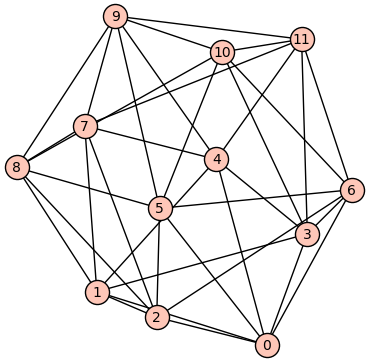

{6: 1, 0: 2, 2: 3, -2: 6}

In [26]:
G = graphs.EmptyGraph()
for _ in range(12):
    G.add_vertex()
G.add_edges([(0,1),(1,2),(0,2), (0,3), (0,4), (1,3), (1, 4), (3, 4), (0,5), (0,6), (2,5), (2,6), (5, 6), (1,7), (1,8), (2,7), (2,8), (7,8), (4,7), (3,6), (5, 8), (8, 9), (7, 9), (5, 10), (6, 10), (3, 11), (4, 11), (11, 7), (11, 9), (11, 6), (11, 10), (9,4), (9, 10), (9,5), (10,8), (10, 3)])
G.show(figsize=5, vertex_size=300)
e_val(G)

In [61]:
print(G.is_regular(), G.is_strongly_regular(), G.diameter(), G.is_distance_regular())

True False 2 False


Cliques Calculated.


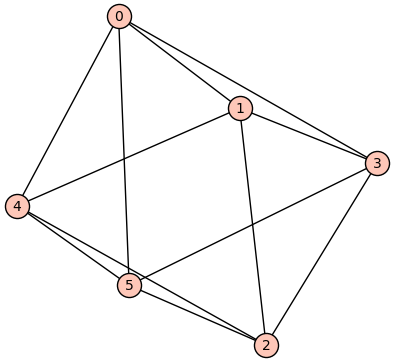

6 4 2 4
{4: 1, -2: 2, 0: 3}


In [29]:
H = clique_construct(G, 4)
H.show(figsize=5, vertex_size=300)
if H.is_strongly_regular():
    print_parameters(H)
    print(e_val(H))

Cliques Calculated.


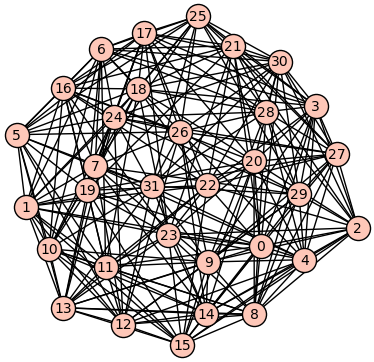

In [67]:
H = clique_construct(G, 3)
H.show(figsize=5, vertex_size=300)
if H.is_strongly_regular():
    print_parameters(H)

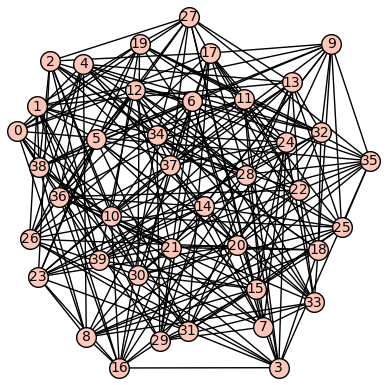

Cliques Calculated.


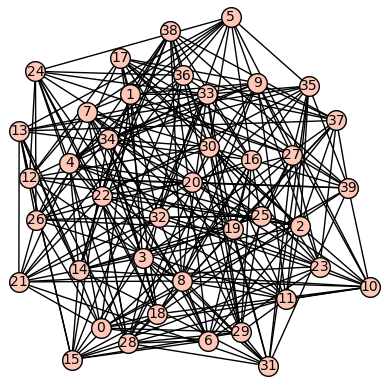

In [78]:
G = graphs.strongly_regular_graph(40,12,2,4)
G.show()
H = clique_construct(G, 4)
H.show()

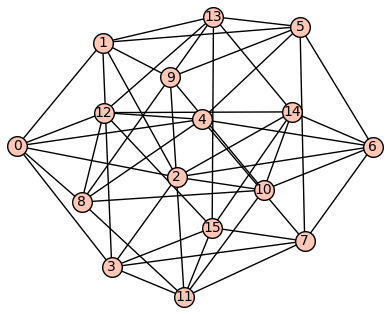

6
3
3
3
3
2
2
2
3
2
2
2
3
2
2
2


In [22]:
G = Graph(graphs.strongly_regular_graph(16, 6, 2, 2).adjacency_matrix())
G.show()
edges = G.neighbors(0)
for vertex in G.vertices():
    K = graphs.EmptyGraph()
    for u in G.neighbors(vertex):
        K.add_edge(vertex, u)
        for v in G.neighbors(u):
            if v in G.neighbors(vertex):
                K.add_edge(v, u)
    print(len(list(set(edges).intersection(K.vertices()))))

[[0, 1, 2, 3, 4], [0, 5, 10, 15, 20], [1, 6, 11, 16, 21], [2, 7, 12, 17, 22], [3, 8, 13, 18, 23], [4, 9, 14, 19, 24], [5, 6, 7, 8, 9], [10, 11, 12, 13, 14], [15, 16, 17, 18, 19], [20, 21, 22, 23, 24]]
[25, 8, 3, 2]


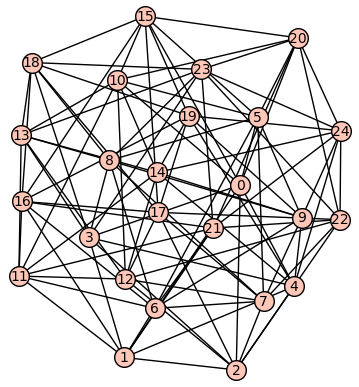

In [33]:
srg = [25, 8, 3, 2]
G = Graph(graphs.strongly_regular_graph(srg[0], srg[1], srg[2], srg[3]).adjacency_matrix())
if srg[2] == 1:
    size = 3
elif srg[2] == 0:
    size = 2
else:
    size = int(srg[1] / srg[3]) + 1
cliques = list(sage.graphs.cliquer.all_max_clique(G))
print(cliques)
for clique_a in cliques:
    for clique_b in cliques:
        if clique_a != clique_b and len(list(set(clique_a).intersection(clique_b))) > 1:
            break
    else:
        break
if clique_b == cliques[len(cliques) - 1]:
    print(srg)
G.show()

In [55]:
G = Graph(graphs.strongly_regular_graph(55, 18, 9, 4).adjacency_matrix())
cliques = list(sage.graphs.cliquer.all_max_clique(G))
print(cliques)
print(len(cliques), len(cliques[0]))

[[0, 1, 3, 6, 10, 15, 21, 28, 36, 45], [0, 2, 4, 7, 11, 16, 22, 29, 37, 46], [1, 2, 5, 8, 12, 17, 23, 30, 38, 47], [3, 4, 5, 9, 13, 18, 24, 31, 39, 48], [6, 7, 8, 9, 14, 19, 25, 32, 40, 49], [10, 11, 12, 13, 14, 20, 26, 33, 41, 50], [15, 16, 17, 18, 19, 20, 27, 34, 42, 51], [21, 22, 23, 24, 25, 26, 27, 35, 43, 52], [28, 29, 30, 31, 32, 33, 34, 35, 44, 53], [36, 37, 38, 39, 40, 41, 42, 43, 44, 54], [45, 46, 47, 48, 49, 50, 51, 52, 53, 54]]
11 10


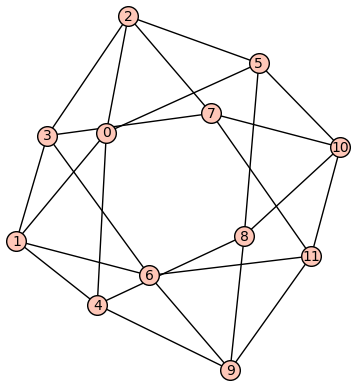

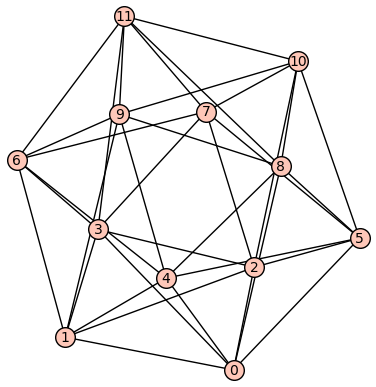

[1, 1, 1, 1, 2, 2, 8, 8, 16, 64, 192, 0]
{1: 4, 2: 2, 8: 2, 16: 1, 64: 1, 192: 1, 0: 1}


NameError: name 'clique_construct' is not defined

In [4]:
size = 4
G = Graph(polytopes.cuboctahedron().graph().adjacency_matrix())
G.show()
cycles = list(filter(lambda x: len(x) == size + 1 and x[1] < x[-2], list(G.to_directed().all_cycles_iterator(simple = True, max_length = size))))
for cycle in cycles:
    for u in cycle:
        for v in cycle:
            if u != v:
                G.add_edge(u, v)
G.show()
HED = G.laplacian_matrix().elementary_divisors()
print(HED)
print(dict((i, HED.count(i)) for i in HED))
H = clique_construct(G, size)
H.show()
HED = H.laplacian_matrix().elementary_divisors()
print(HED)
print(dict((i, HED.count(i)) for i in HED))

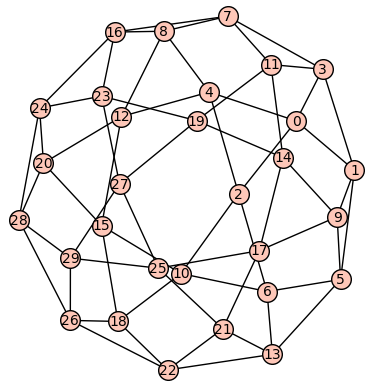

[[0, 1, 5, 6, 2, 0], [0, 3, 7, 8, 4, 0], [1, 3, 11, 14, 9, 1], [2, 4, 12, 15, 10, 2], [5, 9, 17, 21, 13, 5], [6, 10, 18, 22, 13, 6], [7, 11, 19, 23, 16, 7], [8, 12, 20, 24, 16, 8], [14, 17, 25, 27, 19, 14], [15, 18, 26, 28, 20, 15], [21, 22, 26, 29, 25, 21], [23, 24, 28, 29, 27, 23]]
12


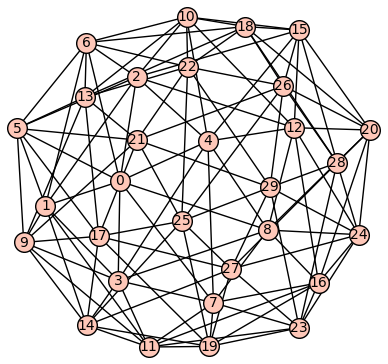

{14: 1, 8: 5, 4: 18, -2: 90, 6.763932022500211?: 3, 11.236067977499789?: 3}
{1: 10, 2: 2, 10: 12, 20: 1, 120: 1, 600: 3, 0: 1}
Cliques Calculated.


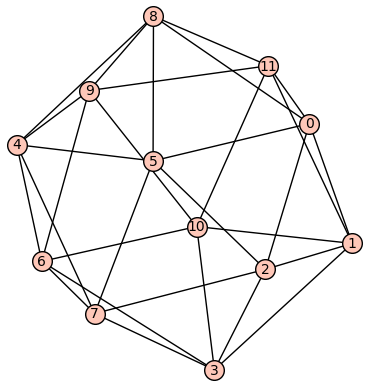

[1, 1, 1, 1, 1, 1, 2, 12, 60, 60, 60, 0]
{1: 6, 2: 1, 12: 1, 60: 3, 0: 1}


In [54]:
size = 5
G = Graph(polytopes.icosidodecahedron().graph().adjacency_matrix())
G.show()
cycles = list(filter(lambda x: len(x) == size + 1 and x[1] < x[-2], list(G.to_directed().all_cycles_iterator(simple = True, max_length = size))))
print(cycles)
print(len(cycles))
for cycle in cycles:
    for u in cycle:
        for v in cycle:
            if u != v:
                G.add_edge(u, v)
G.show()
print(e_val(G.line_graph()))
HED = G.laplacian_matrix().elementary_divisors()
print(dict((i, HED.count(i)) for i in HED))
H = clique_construct(G, 5)
H.show()
HED = H.laplacian_matrix().elementary_divisors()
print(HED)
print(dict((i, HED.count(i)) for i in HED))

Cliques Calculated.
[[0, 3, 4, 17, 20, 55, 88, 89, 90, 91], [1, 8, 9, 27, 34, 37, 60, 65, 74, 75], [2, 13, 14, 47, 50, 73, 93, 95, 98, 99], [5, 18, 21, 25, 26, 28, 61, 66, 76, 77], [6, 19, 22, 23, 30, 31, 58, 63, 68, 69], [7, 32, 33, 42, 80, 81, 82, 83, 84, 85], [10, 16, 35, 38, 40, 41, 49, 52, 56, 57], [11, 24, 36, 39, 43, 44, 59, 64, 71, 72], [12, 45, 46, 70, 86, 87, 92, 94, 96, 97], [15, 29, 48, 51, 53, 54, 62, 67, 78, 79]]


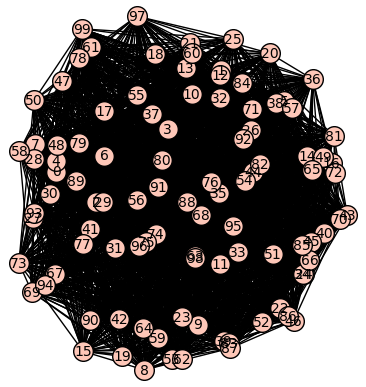

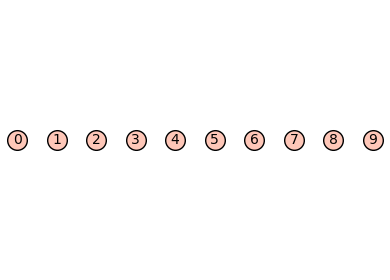

In [13]:
G = Graph(graphs.strongly_regular_graph(100, 55, 30, 30).adjacency_matrix())
H = clique_construct(G, G.clique_number())
print(list(sage.graphs.cliquer.all_max_clique(G)))
G.show()
H.show()

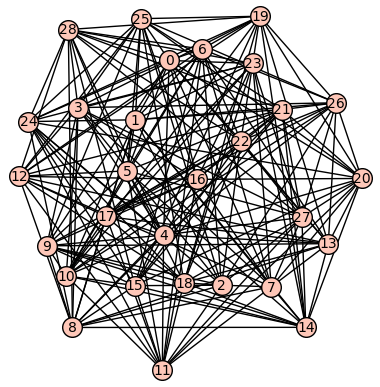

{14: 1, -3.192582403567252?: 14, 2.192582403567252?: 14}
Cycles Calculated.


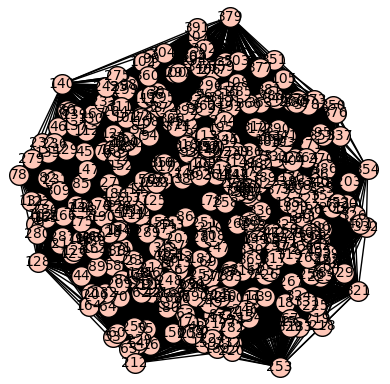

{108: 1, 0: 203, -10.09783467904461?: 2, -1.286208264215581?: 2, -0.6159570567398082?: 2, -9.32443221325216?: 14, -9.05522262683699?: 14, -6.679128842165586?: 14, -6.470326805879766?: 14, -5.463445741473530?: 14, -4.921395679083922?: 14, -4.859252363218215?: 14, -4.216708089626272?: 14, -4.046305611646129?: 14, -2.731888764992257?: 14, -1.906517728773988?: 14, -1.716359387252966?: 14, 14.11936159332451?: 14, 41.27162226087727?: 14}


In [11]:
G = graphs.strongly_regular_graph(29,14,6,7)
G.show()
print(e_val(G))
T = tri_construct(G)
T.show()
print(e_val(T))

True


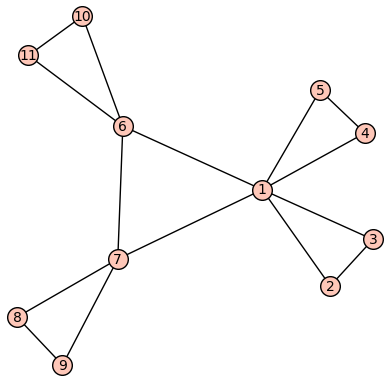

{1: 1,
 -1: 4,
 -2: 4,
 -0.4142135623730951?: 1,
 2.414213562373095?: 1,
 -0.2819202922267223?: 1,
 0.3910879264159741?: 1,
 3.171814772697204?: 1,
 5.719017593113545?: 1}

In [52]:
g = Graph({1: [2, 3, 4, 5, 6, 7], 2: [1, 3], 4: [1, 5], 6: [1, 7, 10, 11], 7:[8, 9], 8:[9], 10:[11]})
print(g.is_cactus())
g.show()
e_val(g.line_graph())

Cliques Calculated.


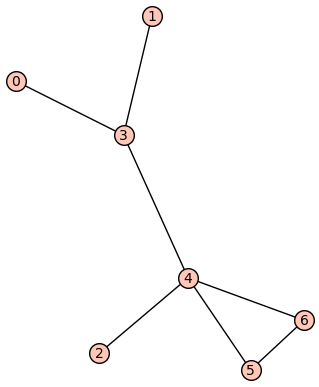

{0: 1,
 -1: 2,
 -2.058959366992821?: 1,
 0.3011429707358127?: 1,
 1.326908559423944?: 1,
 2.430907836833065?: 1}

In [51]:
H = clique_construct(g, 3)
H.show()
e_val(H)

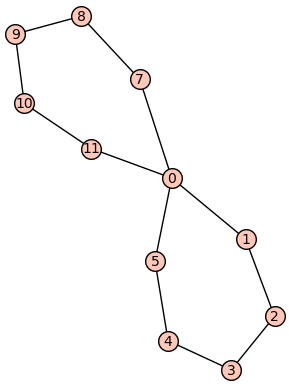

{0: 1,
 1: 2,
 -1: 2,
 -1.732050807568878?: 1,
 1.732050807568878?: 1,
 -2.358294471182263?: 1,
 -1.199352820145586?: 1,
 1.199352820145586?: 1,
 2.358294471182263?: 1}

In [4]:
c6 = graphs.CycleGraph(6)
naphthalene = c6 + c6
naphthalene.merge_vertices([0, 6])
naphthalene.is_cactus()
naphthalene.show()
e_val(naphthalene)

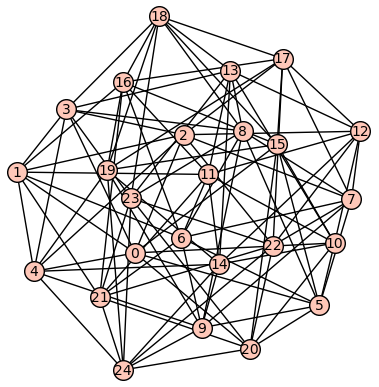

In [33]:
G = Graph(graphs.RookGraph([5,5]).adjacency_matrix())
G.show()

In [19]:
def is_clique_regular(G):
    cliques = list(sage.graphs.cliquer.all_max_clique(G))
    for u, v, _ in G.edges():
        count = 0
        for clique in cliques:
            if u in clique and v in clique:
                count += 1
        if count != 1:
            return False
    return True

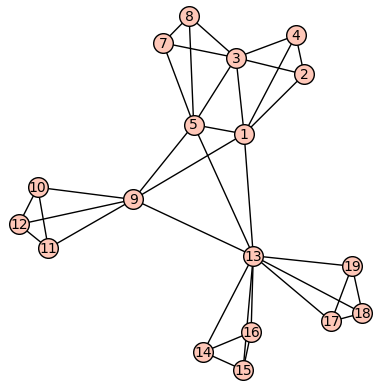

{4: 1,
 3: 1,
 1: 1,
 0: 8,
 -2: 18,
 0.6742264281537081?: 1,
 1.383915867527941?: 1,
 1.683691438061283?: 1,
 3.144519252356066?: 1,
 5.177746828357146?: 1,
 9.217321500275280?: 1,
 6.718578685268576? + 0.?e-168*I: 1}

In [16]:
g = Graph({1: [2, 3, 4, 5, 9, 13], 2: [3, 4], 3: [4, 7, 8], 5: [3, 7, 8, 9, 13], 7: [8], 9: [10, 11, 12, 13], 10: [11, 12], 11: [12], 13: [14, 15, 16, 17, 18, 19], 14: [15, 16], 15: [16], 17: [18, 19], 18: [19]})
g.show()
e_val(g.line_graph())

Cliques Calculated.


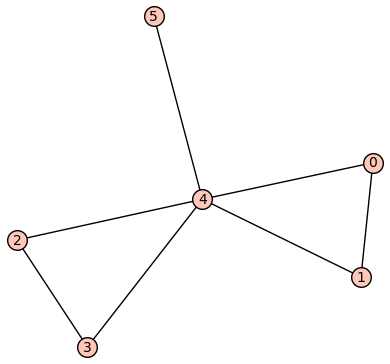

{1: 1,
 -1: 2,
 -1.903211925911554?: 1,
 0.1939365664746305?: 1,
 2.709275359436923?: 1}

In [19]:
H = clique_construct(g, 4)
H.show()
e_val(H)

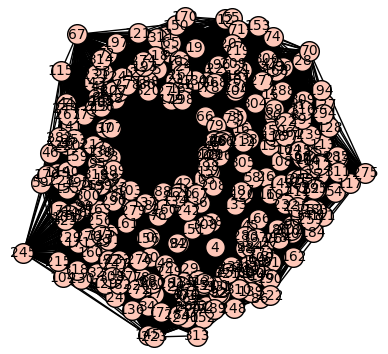

324 119


In [12]:
G = Graph(graphs.OrthogonalArrayBlockGraph(7,18).adjacency_matrix())
G.show()
print(G.num_verts(), G.average_degree())